<a href="https://colab.research.google.com/github/AllanKamimura/2021EstudosPython/blob/main/2021EstudosPython/2%20-%20Analise%20de%20Energia/allan/consumo_brasil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt

from matplotlib.dates import DateFormatter

In [ ]:
file_path = "/content/CONSUMO MENSAL DE ENERGIA ELÉTRICA POR CLASSE.xls"

sheet_name = "TOTAL"
df = pd.read_excel(file_path, sheet_name)
df.to_csv("./consumo_{}.csv".format(sheet_name.lower()),
          index = False)
df.head(10)

,Empresa de Pesquisa Energética - EPE,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,Consumo de energia elétrica na rede (MWh),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Sistema SIMPLES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,2021*,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,JAN,FEV,MAR,ABR,MAI,JUN,JUL,AGO,SET,OUT,NOV,DEZ,ANO
6,TOTAL BRASIL,4.25306e+07,4.12542e+07,4.34163e+07,4.24324e+07,4.03506e+07,4.01816e+07,3.99504e+07,0,0,0,0,0,2.90116e+08
7,REGIÃO GEOGRÁFICA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Norte,2.87721e+06,2.75911e+06,2.90322e+06,2.98352e+06,3.05677e+06,3.06e+06,3.04885e+06,0,0,0,0,0,2.06887e+07
9,Nordeste,7.40022e+06,7.02655e+06,7.24305e+06,7.21888e+06,6.95945e+06,7.01291e+06,6.97839e+06,0,0,0,0,0,4.98395e+07


# Data Clean

In [ ]:
datetime_list = []
consumo_list = []
tipo_list = []
regiao_list = []

first = True
with open("./consumo_{}.csv".format(sheet_name.lower())) as f:

    for line in f.read().split("\n"):
        line_split = line.split(",")

        if first:
            first = False
            continue

        if len(line_split) > 1:
            procurar_ano = re.findall("^[0-9]{4}\*?$", line.split(",")[1])
            # print(line_split)
            if procurar_ano:
                if len(procurar_ano[0]) > 4:
                    ano = procurar_ano[0][:-1]
                else:
                    ano = procurar_ano[0]
                # print(ano)
                
            elif line_split[0]:
                if not line_split[-1]:
                    if "REGIÃO" in line_split[0] or "SUBSISTEMA" in line_split[0]:
                        tipo = line_split[0]
                        # print(tipo)
                elif "TOTAL" in line_split[0]:
                    continue
                    
                else:
                    regiao = line_split[0]
                    consumo_mes = line_split[1:-1]
                    # print(consumo_mes)
                    for i, consumo in enumerate(consumo_mes):
                        data = dt.datetime.strptime("{}-{}".format(ano, str(i + 1).zfill(2)), "%Y-%m")
                        
                        datetime_list.append(data)
                        regiao_list.append(regiao)
                        consumo_list.append(consumo)
                        tipo_list.append(tipo)

# Brasil consumo mensal Dataset

In [ ]:
df = pd.DataFrame({"datetime": datetime_list,
                   "regiao": regiao_list,
                   "consumo": consumo_list,
                   "tipo": tipo_list})


df.set_index('datetime', inplace = True)
df.regiao = df.regiao.astype("category")
df.consumo = df.consumo.astype("float")
df.tipo = df.tipo.astype("category")

df.info()
df.sort_index(inplace = True)
df.head(20)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2160 entries, 2021-01-01 to 2004-12-01
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   regiao   2160 non-null   category
 1   consumo  2160 non-null   float64 
 2   tipo     2160 non-null   category
dtypes: category(2), float64(1)
memory usage: 38.4 KB


,regiao,consumo,tipo
datetime,,,
2004-01-01,Sudeste/C.Oeste,16416445.30,SUBSISTEMA ELÉTRICO
2004-01-01,Nordeste,3719426.79,SUBSISTEMA ELÉTRICO
2004-01-01,Sul,4510113.04,REGIÃO GEOGRÁFICA
2004-01-01,Sistemas Isolados,537166.33,SUBSISTEMA ELÉTRICO
2004-01-01,Centro-Oeste,1507173.86,REGIÃO GEOGRÁFICA
2004-01-01,Sul,4510113.04,SUBSISTEMA ELÉTRICO
2004-01-01,Norte,1574434.34,REGIÃO GEOGRÁFICA
2004-01-01,Norte,1795206.56,SUBSISTEMA ELÉTRICO
2004-01-01,Nordeste,4457112.38,REGIÃO GEOGRÁFICA


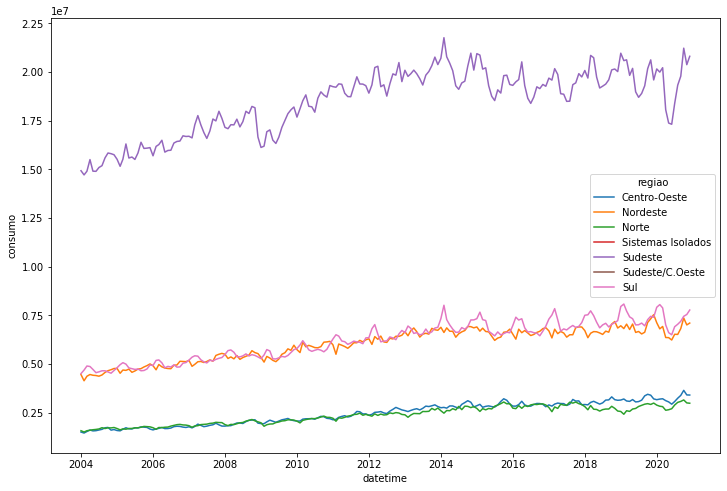

In [ ]:
cut = df.loc[:"2020"][df.loc[:"2020"]["tipo"] == "REGIÃO GEOGRÁFICA"].reset_index()

plt.figure(figsize = (12,8))
sns.lineplot(data = cut, 
             hue = "regiao", 
             y = "consumo",
             x = "datetime")

## Média Móvel Simples

In [ ]:
def moving_average_forecast(series, window_size = 1):
    """Forecasts the mean of the last few values.
    If window_size=1, then this is equivalent to naive forecast"""
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return forecast

In [ ]:
window_size = 6

df_a = df[(df["regiao"] == "Sudeste") & (df["tipo"] == "REGIÃO GEOGRÁFICA")]

moving_average = pd.Series(
    [df_a["consumo"].mean()] * window_size + moving_average_forecast(
        df_a["consumo"], window_size))

moving_average.index = df_a.index

df_a["moving_{}_consumo".format(window_size)] = moving_average
df_a.tail(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,regiao,consumo,tipo,moving_6_consumo
datetime,,,,
2020-05-01,Sudeste,1.737812e+07,REGIÃO GEOGRÁFICA,1.977565e+07
2020-06-01,Sudeste,1.731590e+07,REGIÃO GEOGRÁFICA,1.923483e+07
2020-07-01,Sudeste,1.838112e+07,REGIÃO GEOGRÁFICA,1.885529e+07
2020-08-01,Sudeste,1.932471e+07,REGIÃO GEOGRÁFICA,1.855922e+07
2020-09-01,Sudeste,1.978508e+07,REGIÃO GEOGRÁFICA,1.844760e+07
2020-10-01,Sudeste,2.122441e+07,REGIÃO GEOGRÁFICA,1.837493e+07
2020-11-01,Sudeste,2.037736e+07,REGIÃO GEOGRÁFICA,1.890155e+07
2020-12-01,Sudeste,2.080748e+07,REGIÃO GEOGRÁFICA,1.940143e+07
2021-01-01,Sudeste,2.100207e+07,REGIÃO GEOGRÁFICA,1.998336e+07


Quantidade de valores:  12
Consumo Médio:  19900506.916666668
MAE:  614948.5613888912
MSE:  455292573870.165


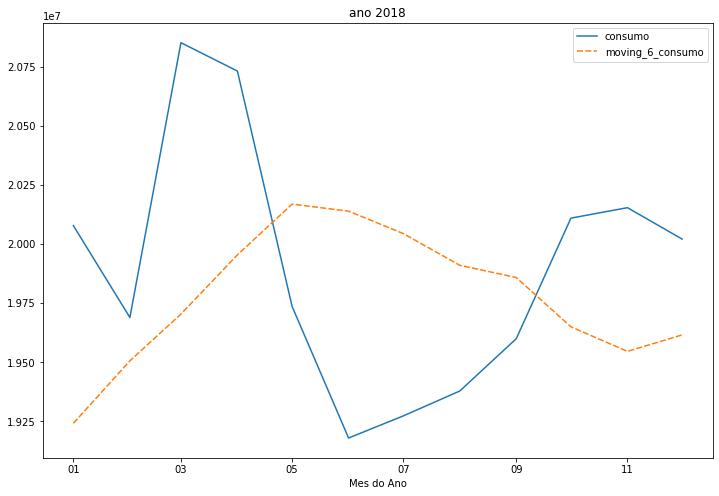

In [ ]:
ano = "2018"
df_ano = df_a.loc[ano]
print("Quantidade de valores: ", df_ano.shape[0])
print("Consumo Médio: ", df_ano["consumo"].mean())
print("MAE: ", tf.keras.metrics.MAE(df_ano["consumo"], df_ano["moving_{}_consumo".format(window_size)]).numpy())
print("MSE: ", tf.keras.metrics.MSE(df_ano["consumo"], df_ano["moving_{}_consumo".format(window_size)]).numpy())

plt.figure(figsize = (12,8))
_ = sns.lineplot(data = df_ano)

plt.xlabel("Mes do Ano")
plt.title("ano {}".format(ano))
date_form = DateFormatter("%m")
_.xaxis.set_major_formatter(date_form)

## Differencing

In [ ]:
def reset_datetime(row):
    month = row.loc["month"].astype("int")
    return dt.datetime.strptime(
        '2004-{}'.format(month),
        '%Y-%m')

In [ ]:
df_a["month"] = df_a.index.month
new_df = df_a.loc["2004",["consumo", "month"]].copy()

for year in df_a.index.year.unique():
    new_df = pd.merge(left = new_df, right = df_a.loc[str(year),["consumo", "month"]], how = "left",
                    on = ["month"], suffixes = ["", "_{}".format(year)])
        
new_df.dropna(inplace = True)
new_df["datetime"] = new_df.apply(lambda row: reset_datetime(row), axis = 1)
new_df.index = new_df.datetime
new_df.drop(["month", "datetime", "consumo"], axis = 1, inplace = True)
new_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,consumo_2004,consumo_2005,consumo_2006,consumo_2007,consumo_2008,consumo_2009,consumo_2010,consumo_2011,consumo_2012,consumo_2013,consumo_2014,consumo_2015,consumo_2016,consumo_2017,consumo_2018,consumo_2019,consumo_2020,consumo_2021
datetime,,,,,,,,,,,,,,,,,,
2004-01-01,14929524.40,15518488.33,15695620.21,16699870.0,17157633.0,16124348.0,17684138.3,19247694.0,18915418.0,20089886.0,20704340.0,20943263.25,19314000.68,19686157.26,20078364.46,20965937.50,20157502.18,2.100207e+07
2004-02-01,14714713.51,15157054.86,16178817.62,16615359.0,17088727.0,16190533.0,18113423.0,19218269.0,19339928.0,19775484.0,21763013.0,20869826.87,19495060.04,19583907.14,19689599.59,20584521.41,19994440.40,2.036601e+07
2004-03-01,14903795.68,15516647.87,16273216.75,17288542.0,17293931.0,16931565.0,18521916.0,19390849.0,20230842.0,19907218.0,20782600.0,20150053.41,19611353.62,20172690.96,20852952.93,20626329.71,20221091.04,2.178592e+07
2004-04-01,15501322.96,16304407.60,16494218.43,17761372.0,17284914.0,17027530.0,18825122.0,19369031.0,20295686.0,20097448.0,20451575.0,20215138.02,20520225.20,19877597.32,20732785.77,19827659.31,18064679.86,2.085787e+07
2004-05-01,14906628.72,15581963.43,15885834.52,17290528.0,17577262.0,16500151.0,18240192.0,18908980.0,19244538.0,19911821.0,20068194.0,19296451.63,19303127.16,18885259.02,19736423.81,20187002.55,17378115.14,1.956155e+07
2004-06-01,14898517.41,15633866.99,15969883.01,16890489.0,17180445.0,16330119.0,18212704.0,18737534.0,19343073.0,19652655.0,19293127.0,18752590.64,18651588.86,18859514.27,19179160.04,18980779.55,17315901.33,1.948128e+07
2004-07-01,15094285.46,15509118.44,15981706.52,16589542.0,17451996.0,16655879.0,17936477.0,18731628.0,18762191.0,19331509.0,19111350.0,18532921.47,18388987.38,18492331.66,19272778.68,18699587.52,18381116.01,1.932603e+07
2004-08-01,15189574.87,15838516.63,16352069.78,16970732.0,17983892.0,17158443.0,18656632.0,19249143.0,19393131.0,19838087.0,19438306.0,19084994.17,18711601.76,18501817.09,19378187.37,18900144.57,19324707.43,0.000000e+00
2004-09-01,15593685.74,16391988.83,16434266.18,17585510.0,17869017.0,17516988.1,18980234.0,19753623.0,19904342.0,20027335.0,19529007.0,18919408.01,19239375.00,19349465.89,19599718.17,19292022.25,19785077.39,0.000000e+00


In [ ]:
df_diff = pd.DataFrame()

for index, coluna in enumerate(new_df.columns):
    if "2004" not in coluna:
        df_diff[coluna] = new_df[new_df.columns[index]] - new_df[new_df.columns[index - 1]]

df_diff

,consumo_2005,consumo_2006,consumo_2007,consumo_2008,consumo_2009,consumo_2010,consumo_2011,consumo_2012,consumo_2013,consumo_2014,consumo_2015,consumo_2016,consumo_2017,consumo_2018,consumo_2019,consumo_2020,consumo_2021
datetime,,,,,,,,,,,,,,,,,
2004-01-01,588963.93,177131.88,1004249.79,457763.0,-1033285.0,1559790.3,1563555.7,-332276.0,1174468.0,614454.0,238923.25,-1629262.57,372156.58,392207.20,887573.04,-808435.32,8.445691e+05
2004-02-01,442341.35,1021762.76,436541.38,473368.0,-898194.0,1922890.0,1104846.0,121659.0,435556.0,1987529.0,-893186.13,-1374766.83,88847.10,105692.45,894921.82,-590081.01,3.715647e+05
2004-03-01,612852.19,756568.88,1015325.25,5389.0,-362366.0,1590351.0,868933.0,839993.0,-323624.0,875382.0,-632546.59,-538699.79,561337.34,680261.97,-226623.22,-405238.67,1.564831e+06
2004-04-01,803084.64,189810.83,1267153.57,-476458.0,-257384.0,1797592.0,543909.0,926655.0,-198238.0,354127.0,-236436.98,305087.18,-642627.88,855188.45,-905126.46,-1762979.45,2.793192e+06
2004-05-01,675334.71,303871.09,1404693.48,286734.0,-1077111.0,1740041.0,668788.0,335558.0,667283.0,156373.0,-771742.37,6675.53,-417868.14,851164.79,450578.74,-2808887.41,2.183439e+06
2004-06-01,735349.58,336016.02,920605.99,289956.0,-850326.0,1882585.0,524830.0,605539.0,309582.0,-359528.0,-540536.36,-101001.78,207925.41,319645.77,-198380.49,-1664878.22,2.165376e+06
2004-07-01,414832.98,472588.08,607835.48,862454.0,-796117.0,1280598.0,795151.0,30563.0,569318.0,-220159.0,-578428.53,-143934.09,103344.28,780447.02,-573191.16,-318471.51,9.449116e+05
2004-08-01,648941.76,513553.15,618662.22,1013160.0,-825449.0,1498189.0,592511.0,143988.0,444956.0,-399781.0,-353311.83,-373392.41,-209784.67,876370.28,-478042.80,424562.86,-1.932471e+07
2004-09-01,798303.09,42277.35,1151243.82,283507.0,-352028.9,1463245.9,773389.0,150719.0,122993.0,-498328.0,-609598.99,319966.99,110090.89,250252.28,-307695.92,493055.14,-1.978508e+07


Quantidade de valores:  12
Consumo Médio:  19870921.561666667
MAE:  806227.6508333342
MSE:  842495099119.0651


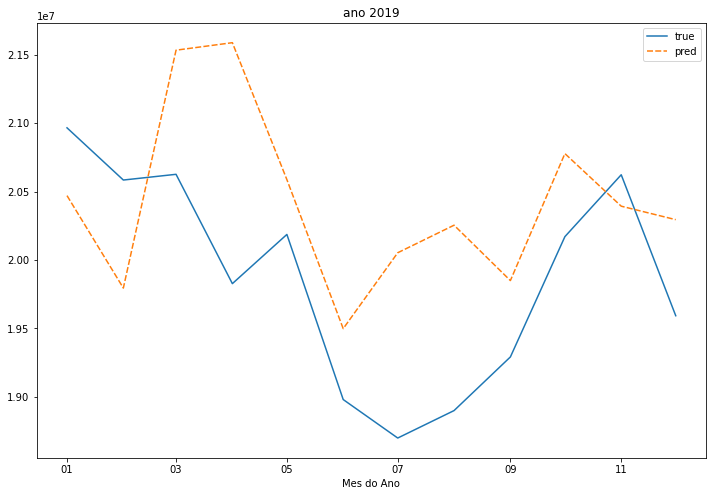

In [ ]:
pred_year = 2019

true = new_df["consumo_{}".format(pred_year)]
pred = new_df["consumo_{}".format(pred_year - 1)] + df_diff["consumo_{}".format(pred_year - 1)]

print("Quantidade de valores: ", true.shape[0])
print("Consumo Médio: ", true.mean())
print("MAE: ", tf.keras.metrics.MAE(true, pred).numpy())
print("MSE: ", tf.keras.metrics.MSE(true, pred).numpy())

plt.figure(figsize = (12,8))
_ = sns.lineplot(data = pd.DataFrame({"true": true, "pred": pred}))

plt.xlabel("Mes do Ano")
plt.title("ano {}".format(pred_year))
date_form = DateFormatter("%m")
_.xaxis.set_major_formatter(date_form)

In [ ]:
window_size = 6

df_b = df[(df["regiao"] == "Sul") & (df["tipo"] == "REGIÃO GEOGRÁFICA")]

moving_average = pd.Series(
    [df_b["consumo"].mean()] * window_size + moving_average_forecast(
        df_b["consumo"], window_size))

moving_average.index = df_b.index

df_b["moving_{}_consumo".format(window_size)] = moving_average

In [ ]:
df_b["month"] = df_b.index.month
new_df_b = df_b.loc["2004",["consumo", "month"]].copy()

for year in df_b.index.year.unique():
    new_df_b = pd.merge(left = new_df_b, right = df_b.loc[str(year),["consumo", "month"]], how = "left",
                    on = ["month"], suffixes = ["", "_{}".format(year)])
        
new_df_b.dropna(inplace = True)
new_df_b["datetime"] = new_df_b.apply(lambda row: reset_datetime(row), axis = 1)
new_df_b.index = new_df_b.datetime
new_df_b.drop(["month", "datetime", "consumo"], axis = 1, inplace = True)

In [ ]:
df_diff_b = pd.DataFrame()

for index, coluna in enumerate(new_df_b.columns):
    if "2004" not in coluna:
        df_diff_b[coluna] = new_df_b[new_df_b.columns[index]] - new_df_b[new_df_b.columns[index - 1]]

## Differencing + Média Móvel

In [ ]:
rename_columns = {i: "consumo_{}".format(ano) for i, ano in zip(range(17), range(2005, 2005 + 17))}
rename_index = {i: dia for i, dia in zip(range(12), new_df.index)}

In [ ]:
diff_array = np.reshape(df_diff.values.T, 12 * 17)
diff_series = pd.Series(diff_array)

window_size = 6

moving_average = np.array(
    [diff_array.mean()] * window_size + moving_average_forecast(
        diff_series, window_size))

new_diff_df = pd.DataFrame(np.reshape(moving_average, (17,12)).T)
new_diff_df.rename(rename_columns, axis = 1, inplace = True)
new_diff_df.rename(rename_index, axis = 0, inplace = True)
new_diff_df

,consumo_2005,consumo_2006,consumo_2007,consumo_2008,consumo_2009,consumo_2010,consumo_2011,consumo_2012,consumo_2013,consumo_2014,consumo_2015,consumo_2016,consumo_2017,consumo_2018,consumo_2019,consumo_2020,consumo_2021
2004-01-01,-199738.426480,457990.713333,4.354837e+05,934216.521667,353640.166667,-1.516887e+05,1.159415e+06,564803.166667,348895.000000,463482.500000,-203329.000000,-650372.228333,-238450.708333,222037.620000,514531.883333,-2.096613e+05,4.368872e+05
2004-02-01,-199738.426480,418373.863333,5.240940e+05,909204.441667,37683.666667,2.409625e+05,1.206574e+06,376898.666667,539545.833333,471005.166667,-126815.291667,-825511.235000,-152435.596667,270181.440000,532386.220000,-2.488686e+05,6.307273e+05
2004-03-01,-199738.426480,480510.696667,5.112587e+05,884988.738333,-280875.333333,6.990190e+05,1.141017e+06,298423.333333,588140.500000,728100.666667,-209049.480000,-995753.735000,-75395.678333,322760.960000,535478.143333,-2.675417e+05,6.218942e+05
2004-04-01,-199738.426480,473554.995000,6.734333e+05,694012.935000,-388520.833333,1.022749e+06,1.041965e+06,309524.000000,509083.333333,853498.833333,-231419.245000,-983937.201667,-35167.286667,417789.473333,455998.893333,-2.837988e+05,8.005235e+05
2004-05-01,-199738.426480,466028.235000,8.215341e+05,442061.225000,-555307.666667,1.384592e+06,9.726867e+05,369461.500000,400569.166667,831255.333333,-267390.908333,-851354.328333,-31108.926667,511151.646667,193880.231667,-5.877480e+05,1.090468e+06
2004-06-01,-199738.426480,469231.960000,9.501196e+05,279743.305000,-764967.166667,1.692130e+06,9.757214e+05,313855.000000,327303.500000,810585.500000,-429704.136667,-661695.423333,-21528.010000,560692.013333,229138.751667,-1.133998e+06,1.495321e+06
2004-07-01,642987.733333,464193.576667,1.008095e+06,172792.000000,-746444.333333,1.748875e+06,8.791436e+05,416188.000000,344171.166667,604722.833333,-472587.530000,-555328.043333,28295.068333,534026.771667,150490.571667,-1.340083e+06,1.653829e+06
2004-08-01,613965.908333,513436.276667,9.420259e+05,240240.500000,-706916.333333,1.702343e+06,7.510762e+05,476661.166667,243312.833333,465620.666667,-608812.826667,-307773.296667,-16506.981667,598733.408333,-92970.128333,-1.258423e+06,1.670552e+06
2004-09-01,648399.310000,428734.675000,9.723793e+05,330205.833333,-694792.166667,1.631559e+06,6.656870e+05,480382.666667,244879.500000,67735.666667,-518833.776667,-140877.560000,-66278.943333,727179.713333,-321797.565000,-1.089315e+06,-1.612160e+06
2004-10-01,679307.793333,309686.086667,9.950324e+05,376558.833333,-693069.316667,1.610375e+06,6.497630e+05,365503.666667,319315.666667,-161216.000000,-515009.176667,2233.570000,-141486.685000,655511.431667,-335309.681667,-9.395998e+05,-5.170478e+06


Quantidade de valores:  12
Consumo Médio:  19870921.561666667
MAE:  741842.1688888908
MSE:  683582469257.0702


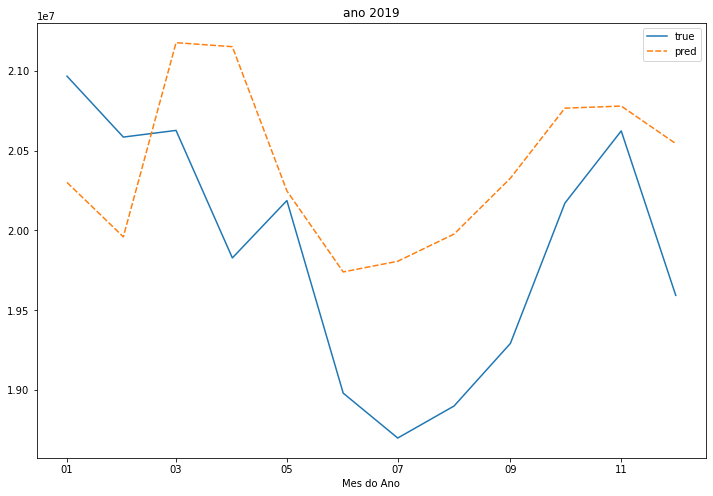

In [ ]:
pred_year = 2019

true = new_df["consumo_{}".format(pred_year)]
pred = new_df["consumo_{}".format(pred_year - 1)] + new_diff_df["consumo_{}".format(pred_year - 1)]

print("Quantidade de valores: ", true.shape[0])
print("Consumo Médio: ", true.mean())
print("MAE: ", tf.keras.metrics.MAE(true, pred).numpy())
print("MSE: ", tf.keras.metrics.MSE(true, pred).numpy())

plt.figure(figsize = (12,8))
_ = sns.lineplot(data = pd.DataFrame({"true": true, "pred": pred}))

plt.xlabel("Mes do Ano")
plt.title("ano {}".format(pred_year))
date_form = DateFormatter("%m")
_.xaxis.set_major_formatter(date_form)

# RNN (train = Sudeste, predict = Sul)

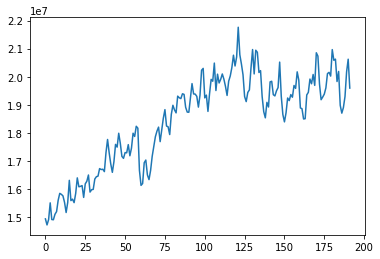

In [ ]:
_ = sns.lineplot(y = np.reshape(new_df.values.T, 12 * 18)[:-24], x = range(12 * 18)[:-24])

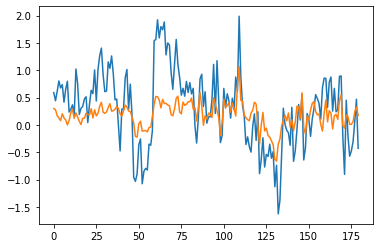

In [ ]:
train_data = np.reshape(df_diff.values.T, 12 * 17)[:-24] / 1000000
valid_data = np.reshape(df_diff_b.values.T, 12 * 17)[:-24] / 1000000

_ = sns.lineplot(y = train_data, x = range(12 * 17)[:-24])
_ = sns.lineplot(y = valid_data, x = range(12 * 17)[:-24])

In [ ]:
window_size = 10
batch_size = 10
shuffle_buffer_size = 30

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

train_set = windowed_dataset(train_data, window_size, batch_size, shuffle_buffer_size)
valid_set = windowed_dataset(valid_data, window_size, batch_size, shuffle_buffer_size)

In [ ]:
model = tf.keras.models.Sequential(
    [tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                            input_shape=[None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(20, activation = "relu"),
    tf.keras.layers.Dense(1),
    ])

epochs = 50
learning_rate = 1e-4
decay_rate = learning_rate / epochs

optimizer = tf.keras.optimizers.SGD(lr = learning_rate, 
                                    momentum = 0.9, 
                                    decay = decay_rate)

model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])

history = model.fit(train_set, validation_data = valid_set, epochs = 100)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
17/17 [==============================] - 6s 30ms/step - loss: 0.3979 - mae: 0.7758 - val_loss: 0.0866 - val_mae: 0.3568
Epoch 2/100
17/17 [==============================] - 0s 11ms/step - loss: 0.3211 - mae: 0.6811 - val_loss: 0.0627 - val_mae: 0.2991
Epoch 3/100
17/17 [==============================] - 0s 12ms/step - loss: 0.2721 - mae: 0.6170 - val_loss: 0.0478 - val_mae: 0.2532
Epoch 4/100
17/17 [==============================] - 0s 12ms/step - loss: 0.2429 - mae: 0.5756 - val_loss: 0.0372 - val_mae: 0.2168
Epoch 5/100
17/17 [==============================] - 0s 12ms/step - loss: 0.2213 - mae: 0.5421 - val_loss: 0.0301 - val_mae: 0.1899
Epoch 6/100
17/17 [==============================] - 0s 12ms/step - loss: 0.2055 - mae: 0.5158 - val_loss: 0.0260 - val_mae: 0.1753
Epoch 7/100
17/17 [==============================] - 0s 11ms/step - loss: 0.1935 - mae: 0.4946 - val_loss: 0.0241 - val_mae: 0.1696
Epoch 8/100
17/17 [==============================] - 0s 11ms/step - loss: 0.

Quantidade de valores:  12
Consumo Médio:  7394819.73175
MAE:  184821.48512393804
MSE:  63582668697.85563


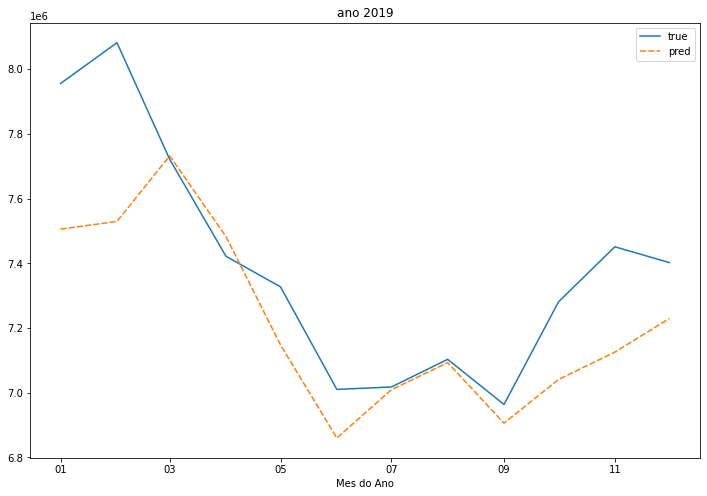

In [ ]:
pred_year = 2019

true = new_df_b["consumo_{}".format(pred_year)]
pred = new_df_b["consumo_{}".format(pred_year - 1)] + pred_diff.squeeze()[-12:]

print("Quantidade de valores: ", true.shape[0])
print("Consumo Médio: ", true.mean())
print("MAE: ", tf.keras.metrics.MAE(true, pred).numpy())
print("MSE: ", tf.keras.metrics.MSE(true, pred).numpy())

plt.figure(figsize = (12,8))
_ = sns.lineplot(data = pd.DataFrame({"true": true, "pred": pred}))

plt.xlabel("Mes do Ano")
plt.title("ano {}".format(pred_year))
date_form = DateFormatter("%m")
_.xaxis.set_major_formatter(date_form)

Quantidade de valores:  12
Consumo Médio:  7221905.685
MAE:  170160.49353164397
MSE:  41522819025.183174


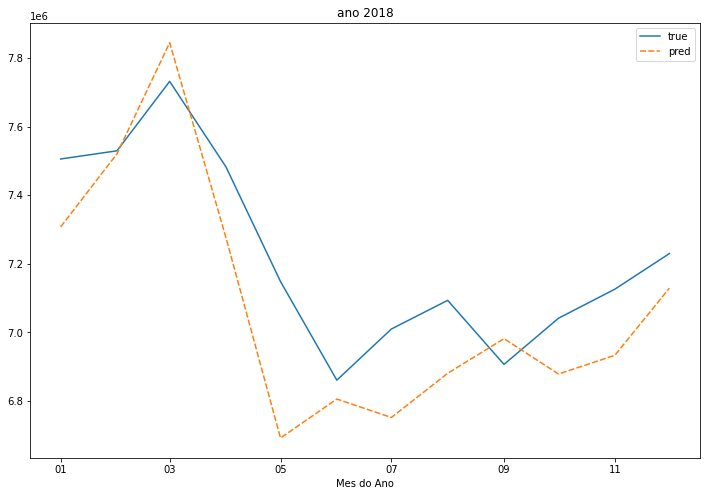

In [ ]:
pred_year = 2018

true = new_df_b["consumo_{}".format(pred_year)]
pred = new_df_b["consumo_{}".format(pred_year - 1)] + pred_diff.squeeze()[-24:-12]

print("Quantidade de valores: ", true.shape[0])
print("Consumo Médio: ", true.mean())
print("MAE: ", tf.keras.metrics.MAE(true, pred).numpy())
print("MSE: ", tf.keras.metrics.MSE(true, pred).numpy())

plt.figure(figsize = (12,8))
_ = sns.lineplot(data = pd.DataFrame({"true": true, "pred": pred}))

plt.xlabel("Mes do Ano")
plt.title("ano {}".format(pred_year))
date_form = DateFormatter("%m")
_.xaxis.set_major_formatter(date_form)